دانلود دیتاست مورد استفاده:   https://www.mediafire.com/file/j03djpy140rno4d/data.rar/file

* کتابخانه ها

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

* ورود دیتاست
* چاپ تعداد کلاس

In [2]:
data_dir = "data"
categories = os.listdir(data_dir)
image_size = (32, 32)
num_classes = len(categories)
valid_formats = ('.jpg', '.png', '.gif', '.jpeg')

print(f'num_classes = ' , num_classes)

num_classes =  3


*  شمارش تعداد تصاویر هر کلاس و فرمت های موجود

In [3]:
for category in categories:  
    category_path = os.path.join(data_dir, category)
    image_count = len([file for file in os.listdir(category_path) 
                       if file.lower().endswith(valid_formats)])
    
    format_count = {ext: 0 for ext in valid_formats}
    
    for file in os.listdir(category_path):
        file_lower = file.lower()
        for ext in valid_formats:
            if file_lower.endswith(ext):
                format_count[ext] += 1
    print(f"Number_Images_{category} : {image_count} images.")

    for ext, count in format_count.items():
        print(f"\n",f"                 {ext}: {count}")
        

Number_Images_Angry : 86 images.

                  .jpg: 67

                  .png: 14

                  .gif: 0

                  .jpeg: 5
Number_Images_Happy : 100 images.

                  .jpg: 80

                  .png: 8

                  .gif: 0

                  .jpeg: 12
Number_Images_Sad : 79 images.

                  .jpg: 69

                  .png: 4

                  .gif: 1

                  .jpeg: 5


* تعریف تابع  تغییر یافته برای حفظ ابعاد تصویر 

In [4]:
def load_data(data_dir, categories, valid_formats, img_size):
    images = []
    labels = []
    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        for file in os.listdir(category_path):
            if file.lower().endswith(valid_formats):
                file_path = os.path.join(category_path, file)
                try:
                    if file.lower().endswith('.gif'):
                        img = Image.open(file_path)
                        img = img.convert('RGB')
                        img_resized = img.resize(img_size, Image.LANCZOS)
                        img_array = np.array(img_resized)
                    else:
                        img = cv2.imread(file_path, cv2.IMREAD_COLOR)
                        if img is not None:
                            img_array = cv2.resize(img, img_size)
                            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                    
                    img_array = img_array / 255.0
                    img_array = img_array.transpose(2, 0, 1)  # (Channel(32*32*3),Height,Width)
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return np.array(images), np.array(labels)

* بارگذاری و آماده‌سازی داده‌ها

In [5]:
images, labels = load_data(data_dir, categories, valid_formats, image_size)

* تقسیم داده‌ها به آموزشی و آزمایشی 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [7]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (212, 3, 32, 32)
y_train shape: (212,)


*  تبدیل به تنسور

In [8]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

* تعریف بلوک ResNet

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, 
                                                    kernel_size=1, stride=stride, bias=False),
                                                    nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out


* تعریف مدل ResNet

In [10]:
class ResNet(nn.Module):
    def __init__(self, block, num_classes=7):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(block, 64, 2, stride=1)
        self.layer2 = self.make_layer(block, 128, 2, stride=2)
        self.layer3 = self.make_layer(block, 256, 2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


* Device

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


* مقداردهی اولیه به مدل

In [12]:
model = ResNet(ResidualBlock, num_classes=num_classes).to(device)

* تابع زیان و بهینه‌ساز

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


* پارامترهای آموزشی

In [14]:
num_epochs = 50
batch_size = 32

* حلقه آموزش

In [15]:
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size].to(device)
        batch_y = y_train[i:i+batch_size].to(device)
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/50], Loss: 0.6029
Epoch [10/50], Loss: 0.2578
Epoch [15/50], Loss: 0.3552
Epoch [20/50], Loss: 0.0759
Epoch [25/50], Loss: 0.0190
Epoch [30/50], Loss: 0.0114
Epoch [35/50], Loss: 0.0637
Epoch [40/50], Loss: 0.0032
Epoch [45/50], Loss: 0.0011
Epoch [50/50], Loss: 0.0008


* ارزیابی

In [19]:
def predict_emotion(model, image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img_resized = img.resize(image_size, Image.LANCZOS)
    img_array = np.array(img_resized) / 255.0
    img_array = img_array.transpose(2, 0, 1)
    img_tensor = torch.FloatTensor(img_array).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs.data, 1)
        emotion_name = categories[predicted.item()]
    
    plt.imshow(img)
    plt.title(f'Predicted Emotion: {emotion_name}')
    plt.axis('off')
    plt.show()
    
    return emotion_name

with torch.no_grad():
    test_outputs = model(X_test.to(device))
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = (predicted == y_test.to(device)).float().mean()
    print(f'Test Accuracy: {accuracy.item()*100:.2f}%')

Test Accuracy: 77.36%


* پیش‌بینی 

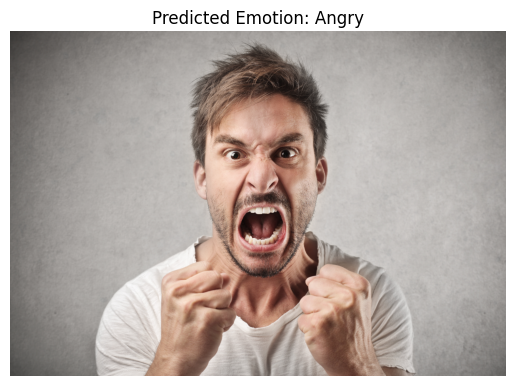

In [20]:
image_path = "H:/codes/project_1403/data/Angry/Angry-Man.jpeg"  
predicted_emotion = predict_emotion(model, image_path)  
#print(f'Predicted Emotion: {predicted_emotion}')

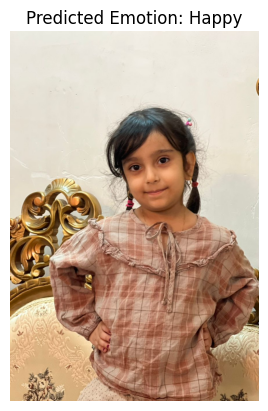

In [21]:
image_path = "H:/codes/project_1403/aras/_5.jpeg"   
predicted_emotion = predict_emotion(model, image_path)  
#print(f'Predicted Emotion: {predicted_emotion}')